<a href="https://colab.research.google.com/github/technisekai/sentiment-analysis-of-new-halal-logo/blob/main/3_pengolahan_data_lanjutan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3. Pengolahan Data**

Proses Sebelumnya : [**2. Preanalisis Data**](https://colab.research.google.com/drive/14v2qJpYfPWSzGsG04yGmc2OwPfomRnbW)

## 3.1 Install dan Impor Library

In [1]:
# untuk menggunakan model indonesian sentiment
#!pip install transformers

In [2]:
# download stopword
!gdown --id 19nlMainHfItPZ4_9K1yS3WZgk8nJW1p5
# download normalisasi kata
!gdown --id 1cINKFxiSycaOwVY5O5SPAxEwuhKRvqSz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19nlMainHfItPZ4_9K1yS3WZgk8nJW1p5
To: /content/stopwordbahasa.csv
100% 6.45k/6.45k [00:00<00:00, 9.40MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1cINKFxiSycaOwVY5O5SPAxEwuhKRvqSz
To: /content/new_kamusalay.csv
100% 286k/286k [00:00<00:00, 110MB/s]


In [3]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 5.1 MB/s 


In [4]:
import cv2
import re
import pandas as pd
import numpy as np
import imblearn
import warnings
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn import metrics as m
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

# preparing var to stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# preparing normalize word
alay_dict = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
# preparing remove stopword
id_stopword_dict = pd.read_csv('stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

## 3.2 Data Cleansing

meliputi proses mengubah huruf 

*   mengubah huruf kapital menjadi huruf kecil.
*   menghilangkan kata tidak penting seperti \n, simbol retweet, username, url, dan spasi ekstra.
*   Normalisasi kata
*   Stemming

In [5]:
# impor dataset
df = pd.read_csv('/content/drive/MyDrive/Dataset/tugas-akhir/labeled/logo-halal-labeled-with-indonesia-sentiment.csv')

In [24]:
import re

# lowercase
def lowercase(text):
    return text.lower()

# remove uncertain word in sentence
def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('&([a-zA-Z0-9_]{1,50})', ' ', text) # remove html code
    text = re.sub('#([a-zA-Z0-9_]{1,50})', ' ', text) # remove hashtag
    text = re.sub('@[^\s]+',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

# remove non-alphanumeruic   
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    text = re.sub(r'[-+]?[0-9]+', '', text)
    return text

# stemming
def stemming(text):
    return stemmer.stem(text)

# normalization
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

# remove stopword
def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

# preprocessing using function defined above
def preprocess(text):
    text = lowercase(text) # 1
    text = remove_unnecessary_char(text) # 2
    text = remove_nonaplhanumeric(text) # 3
    text = normalize_alay(text) # 4
    text = remove_stopword(text) # 6
    text = stemming(text) # 5
    return text

In [25]:
# memanggil fungsi prepoecess untuk cleansing kolom normalization_tweet
df['clean_tweet'] = df['normalization_tweet'].apply(preprocess)

In [26]:
# menampilkan data
df[['normalization_tweet', 'clean_tweet']].head()

,normalization_tweet,clean_tweet
0,eh… saya bukan muslim tapi saya hanya ingin me...,eh muslim dapat suka logo halal
1,"intinya bukan labelnya yang budaya bang, tetap...",inti label budaya bang bentuk logo sih selera ...
2,"ayo jangan terkecoh sama isu adzan, logo halal...",ayo kecoh isu azan logo halal kemah titik beta...
3,"dengan terbitnya logo baru, menteri agama yaqu...",terbit logo menteri agama yaqut cholil qoumas ...
4,logo halal islam nusantara...alias liberal...,logo halal islam nusantara alias liberal


In [27]:
# ubah label menjadi numeric
def label_to_num(label):
  if label == 'positive':
    return 1
  elif label == 'negative':
    return -1
  else:
    return 0

In [28]:
# memanggil fungsi label_to_num
df['class_data'] = df['sentiment'].apply(label_to_num)

In [29]:
# dict
slang_word = {}

# lanjutan cleaning analisis
with open ('lanjutan_cleaning.txt', 'r') as txt:
  for i in txt:
    split = i.split(' -> ')
    slang_word[split[0]] = split[1].replace('\n', '')

In [ ]:
unknown_df = pd.DataFrame()
unknown_word = [i for i in advance_clean if advance_clean[i] == '?']

def search_word(text):
  text_split = text.split(' ')
  for i in unknown_word:
    for j in text_split:
      if i == j:
        return text, i

In [ ]:
unknown_df['found'] = df['clean_tweet'].apply(search_word)

In [ ]:
unknown_df.dropna()

,found
14,(logo referensi tulis arab konsisten kaidah kh...
18,(tuju bentuk kaligrafi logo halal tante usul g...
20,(kemnaker kreasi bikin undang undang jht mente...
37,(desain gue bilang sih cakap fungsi logo halal...
59,(logo halal cermin sederhana ala nu kaligrafi ...
...,...
957,(anjim lihat gue barusan ben logo warna ungu s...
960,(kemarin kh miftahul akhyar paksa undur ketua ...
973,(logo halal ubah panas case wayang ya wayang d...
983,(seek logo halal tulis halal ky undang tonton ...


In [ ]:
# definisi atribut dan label
X = df['clean_tweet'].values
y = df['class_data'].values

## 3.3 Data Labeling

In [ ]:
!git lfs install
!git clone https://huggingface.co/sahri/indonesiasentiment
!pip install transformers

In [ ]:
from transformers import pipeline

pretrained_name = "/content/indonesiasentiment"

nlp = pipeline(
    "sentiment-analysis",
    model=pretrained_name,
    tokenizer=pretrained_name
)


In [ ]:
# definisi fungsi untuk labeling
def labeling(text):
  x = nlp(text)
  return x[0]['label']

In [ ]:
# panggil fungsi labeling dan buat kolom baru
df['sentiment'] = df['normalization_tweet'].apply(labeling)

## 3.4 Split Data 80:20

Memisah data latih dan uji dengan proporsi 80:20.

In [ ]:
# split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
a, b, c, d = X_train, X_test, y_train, y_test

In [ ]:
def show_info_label(x):
  return Counter(x)

In [ ]:
# tampilkan jumlah data
print("Jumlah data latih : ", len(X_train))
print("Jumlah data Uji : ", len(X_test))

Jumlah data latih :  800
Jumlah data Uji :  200


In [ ]:
# tampilkan jumlah label setiap data
print("Jumlah label data pada data latih: ", show_info_label(y_train))
print("Jumlah label data pada data uji: ", show_info_label(y_test))

Jumlah label data pada data latih:  Counter({-1: 497, 1: 153, 0: 150})
Jumlah label data pada data uji:  Counter({-1: 125, 0: 42, 1: 33})


## 3.5 TF-IDF

Mengubah kalimat menjadi vector angka numerik.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# ubah teks ke vektor berdasar data train
tf_idf = TfidfVectorizer()
tf_idf.fit(X_train)

TfidfVectorizer()

In [ ]:
# ubah teks ke vektor
X_train = tf_idf.transform(X_train).toarray()
X_test = tf_idf.transform(X_test).toarray()

In [ ]:
# menampilkan data hasil tf-idf data latih
X_train_pd = pd.DataFrame(X_train, columns=tf_idf.get_feature_names_out())
X_train_pd.head()

,abbas,abjad,about,abu,abur,acara,acc,aceh,achmadi,acu,...,your,youtube,yoweslah,yudhoyono,yuk,zalik,zalim,zaman,zat,zi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# menampilkan data hasil tf-idf data uji
X_test_pd = pd.DataFrame(X_test, columns=tf_idf.get_feature_names_out())
X_test_pd.head()

,abbas,abjad,about,abu,abur,acara,acc,aceh,achmadi,acu,...,your,youtube,yoweslah,yudhoyono,yuk,zalik,zalim,zaman,zat,zi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.6 Over and Under Sampling

Menyamakan proporsi data antara sentimen positif dan negatif.

In [ ]:
# oversampling
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
# info label
show_info_label(y_train_over)

Counter({-1: 492, 0: 492, 1: 492})

In [ ]:
# undersampling
undersample = RandomUnderSampler()
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
# info label
show_info_label(y_train_under)

Counter({-1: 153, 0: 153, 1: 153})

In [ ]:
data = {
    'original': (X_train, y_train),
    'oversampling': (X_train_over, y_train_over),
    'undersampling': (X_train_under, y_train_under)
    }

In [ ]:
print("original data : ", len(data['original'][0]))
print("oversampling data : ", len(data['oversampling'][0]))
print("undersampling data : ", len(data['undersampling'][0]))

original data :  800
oversampling data :  1476
undersampling data :  459


## 3.7 Implementasi SVM dan Evaluasi

### 3.7.1 Implementasi SVM dengan Kernel RBF

In [ ]:
# nilai pada setiap parameter pada kernel rbf yang akan digunakan
param = {
    'kernel': ['rbf'],
    'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1, 1, 10, 100]
}

In [ ]:
from sklearn.model_selection import GridSearchCV

# mencari parameter terbaik dengan grisearch
grid_search = GridSearchCV(estimator=SVC(random_state=0),
                           param_grid=param,
                           n_jobs=8,
                           verbose=1,
                           scoring='accuracy')

In [ ]:
# proses pelatihan dan prediksi
def training(X_train, y_train, X_test):
  grid_search.fit(X_train, y_train)
  y_pred = grid_search.predict(X_test)
  return grid_search, y_pred

# menampilkan akurasi dan parameter yang didapat
def report_gs(grid_search):
  print("Akurasi yang didapat: ", grid_search.best_score_)
  # param to pandas
  best_param = pd.DataFrame()
  best_param['params'] = list(grid_search.best_estimator_.get_params().keys())
  best_param['values'] = list(grid_search.best_estimator_.get_params().values())
  print("\nKombinasi parameter yang didapat: ", )
  print(best_param.to_markdown())

# menampilkan hasil dalam bentuk classification report dan confusion matrix
def report_result(y_test, y_pred):
  return classification_report(y_test, y_pred), confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])

### 3.7.2 Evaluasi pada Data Asli

In [ ]:
# proses pelatihan
data_original = training(X_train, y_train, X_test)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


In [ ]:
# hasil akurasi dan parameter yang didapat
report_gs(data_original[0])

Akurasi yang didapat:  0.64625

Kombinasi parameter yang didapat: 
|    | params                  | values   |
|---:|:------------------------|:---------|
|  0 | C                       | 10       |
|  1 | break_ties              | False    |
|  2 | cache_size              | 200      |
|  3 | class_weight            |          |
|  4 | coef0                   | 0.0      |
|  5 | decision_function_shape | ovr      |
|  6 | degree                  | 3        |
|  7 | gamma                   | 1        |
|  8 | kernel                  | rbf      |
|  9 | max_iter                | -1       |
| 10 | probability             | False    |
| 11 | random_state            | 0        |
| 12 | shrinking               | True     |
| 13 | tol                     | 0.001    |
| 14 | verbose                 | False    |


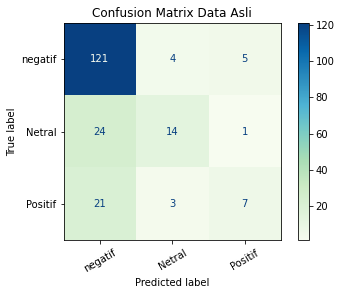




              precision    recall  f1-score   support

          -1       0.73      0.93      0.82       130
           0       0.67      0.36      0.47        39
           1       0.54      0.23      0.32        31

    accuracy                           0.71       200
   macro avg       0.64      0.51      0.53       200
weighted avg       0.69      0.71      0.67       200



In [ ]:
# hasil keseluruhan
classify_report, cm = report_result(y_test, data_original[1])

# confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negatif', 'Netral', 'Positif'])
disp.plot(cmap='GnBu')
plt.title('Confusion Matrix Data Asli')
plt.xticks(rotation=30, horizontalalignment="center")
plt.show()
print('\n\n')
# classification report
print(classify_report)

### 3.7.3 Evaluasi pada Data Oversampling

In [ ]:
# proses pelatihan
data_over = training(X_train_over, y_train_over, X_test)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


In [ ]:
# hasil akurasi dan parameter yang didapat
report_gs(data_over[0])

Akurasi yang didapat:  0.9066032982134675

Kombinasi parameter yang didapat: 
|    | params                  | values   |
|---:|:------------------------|:---------|
|  0 | C                       | 10       |
|  1 | break_ties              | False    |
|  2 | cache_size              | 200      |
|  3 | class_weight            |          |
|  4 | coef0                   | 0.0      |
|  5 | decision_function_shape | ovr      |
|  6 | degree                  | 3        |
|  7 | gamma                   | scale    |
|  8 | kernel                  | rbf      |
|  9 | max_iter                | -1       |
| 10 | probability             | False    |
| 11 | random_state            | 0        |
| 12 | shrinking               | True     |
| 13 | tol                     | 0.001    |
| 14 | verbose                 | False    |


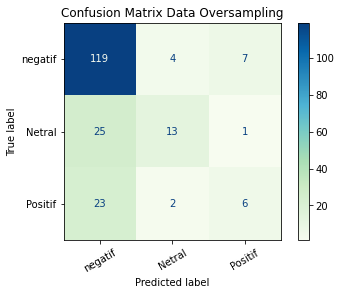




              precision    recall  f1-score   support

          -1       0.71      0.92      0.80       130
           0       0.68      0.33      0.45        39
           1       0.43      0.19      0.27        31

    accuracy                           0.69       200
   macro avg       0.61      0.48      0.51       200
weighted avg       0.66      0.69      0.65       200



In [ ]:
# hasil keseluruhan
classify_report, cm = report_result(y_test, data_over[1])

# confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negatif', 'Netral', 'Positif'])
disp.plot(cmap='GnBu')
plt.title('Confusion Matrix Data Oversampling')
plt.xticks(rotation=30, horizontalalignment="center")
plt.show()
print('\n\n')
# classification report
print(classify_report)

### 3.7.4 Evaluasi pada Data Undersampling

In [ ]:
# proses pelatihan
data_under = training(X_train_under, y_train_under, X_test)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


In [ ]:
# hasil akurasi dan parameter yang didapat
report_gs(data_under[0])

Akurasi yang didapat:  0.5620640229335881

Kombinasi parameter yang didapat: 
|    | params                  | values   |
|---:|:------------------------|:---------|
|  0 | C                       | 1        |
|  1 | break_ties              | False    |
|  2 | cache_size              | 200      |
|  3 | class_weight            |          |
|  4 | coef0                   | 0.0      |
|  5 | decision_function_shape | ovr      |
|  6 | degree                  | 3        |
|  7 | gamma                   | scale    |
|  8 | kernel                  | rbf      |
|  9 | max_iter                | -1       |
| 10 | probability             | False    |
| 11 | random_state            | 0        |
| 12 | shrinking               | True     |
| 13 | tol                     | 0.001    |
| 14 | verbose                 | False    |


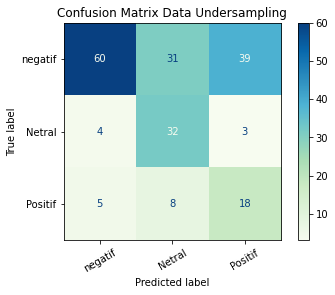




              precision    recall  f1-score   support

          -1       0.87      0.46      0.60       130
           0       0.45      0.82      0.58        39
           1       0.30      0.58      0.40        31

    accuracy                           0.55       200
   macro avg       0.54      0.62      0.53       200
weighted avg       0.70      0.55      0.57       200



In [ ]:
# hasil keseluruhan
classify_report, cm = report_result(y_test, data_under[1])

# confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negatif', 'Netral', 'Positif'])
disp.plot(cmap='GnBu')
plt.title('Confusion Matrix Data Undersampling')
plt.xticks(rotation=30, horizontalalignment="center")
plt.show()
print('\n\n')
# classification report
print(classify_report)